In [1]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from torch.utils.data import DataLoader
from model_runs.model_run_helpers import *
import matplotlib.pyplot as plt

In [2]:
model_path = "/homes/vk223/ProjectFlood/models/saved_models/convLSTM_separate_branches_9999_20240801.pt"
model_path = "/homes/vk223/ProjectFlood/models/saved_models/ConvLSTMSeparateBranches_num_epochs3000_trainbatchsize32_lr0p0001_precedingrainfalldays1_dropoutprob0p0_outputchannels20_convblocklayers5_convLSTMlayers3_optimizerRMSprop_criterionBCELoss_20240808_3000.pt"
model, _, _, _ = load_checkpoint(model_path)

model.eval()
print(model.parameters())

/homes/vk223/ProjectFlood/model_runs/model_run_helpers.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)
/vol/bitbucket/vk223/project_f

<generator object Module.parameters at 0x7dc064a5bed0>


In [3]:
os.environ["PROJECT_FLOOD_DATA"] = "/homes/vk223/ProjectFlood/static/imperial_data_paths.json"
print(os.environ["PROJECT_FLOOD_DATA"])
test_batch_size = 8
test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=1, forecast_rainfall_days=1, 
                                  transform=None, batch_size=test_batch_size, shuffle=True, num_workers=4)
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)
# test_images, test_labels = test_set.get_random_batch(4)
# test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
# test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
outputs = model(test_images)
# logits = torch.sigmoid(outputs)

/homes/vk223/ProjectFlood/static/imperial_data_paths.json


Max Logit: 0.9675864577293396, Min Logit: 0.00014134758384898305, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(55696))
Max Logit: 0.9989455342292786, Min Logit: 0.00014134758384898305, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(16797))
Max Logit: 0.9959424138069153, Min Logit: 2.0066596334800124e-05, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(14207))
Max Logit: 0.9589143991470337, Min Logit: 0.00014134758384898305, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(50795))
Max Logit: 0.998543381690979, Min Logit: 0.00014134758384898305, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(53187))
Max Logit: 0.987431526184082, Min Logit: 8.708960376679897e-05, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(29019))
Max Logit: 0.9999408721923828, Min Logit: 1.200234328280203e-05, Mode: ModeResult(mode=np.float32(0.15687716), count=np.int64(7316))
Max Logit: 0.9999462366104126, Min Logit: 4.114313924219459e

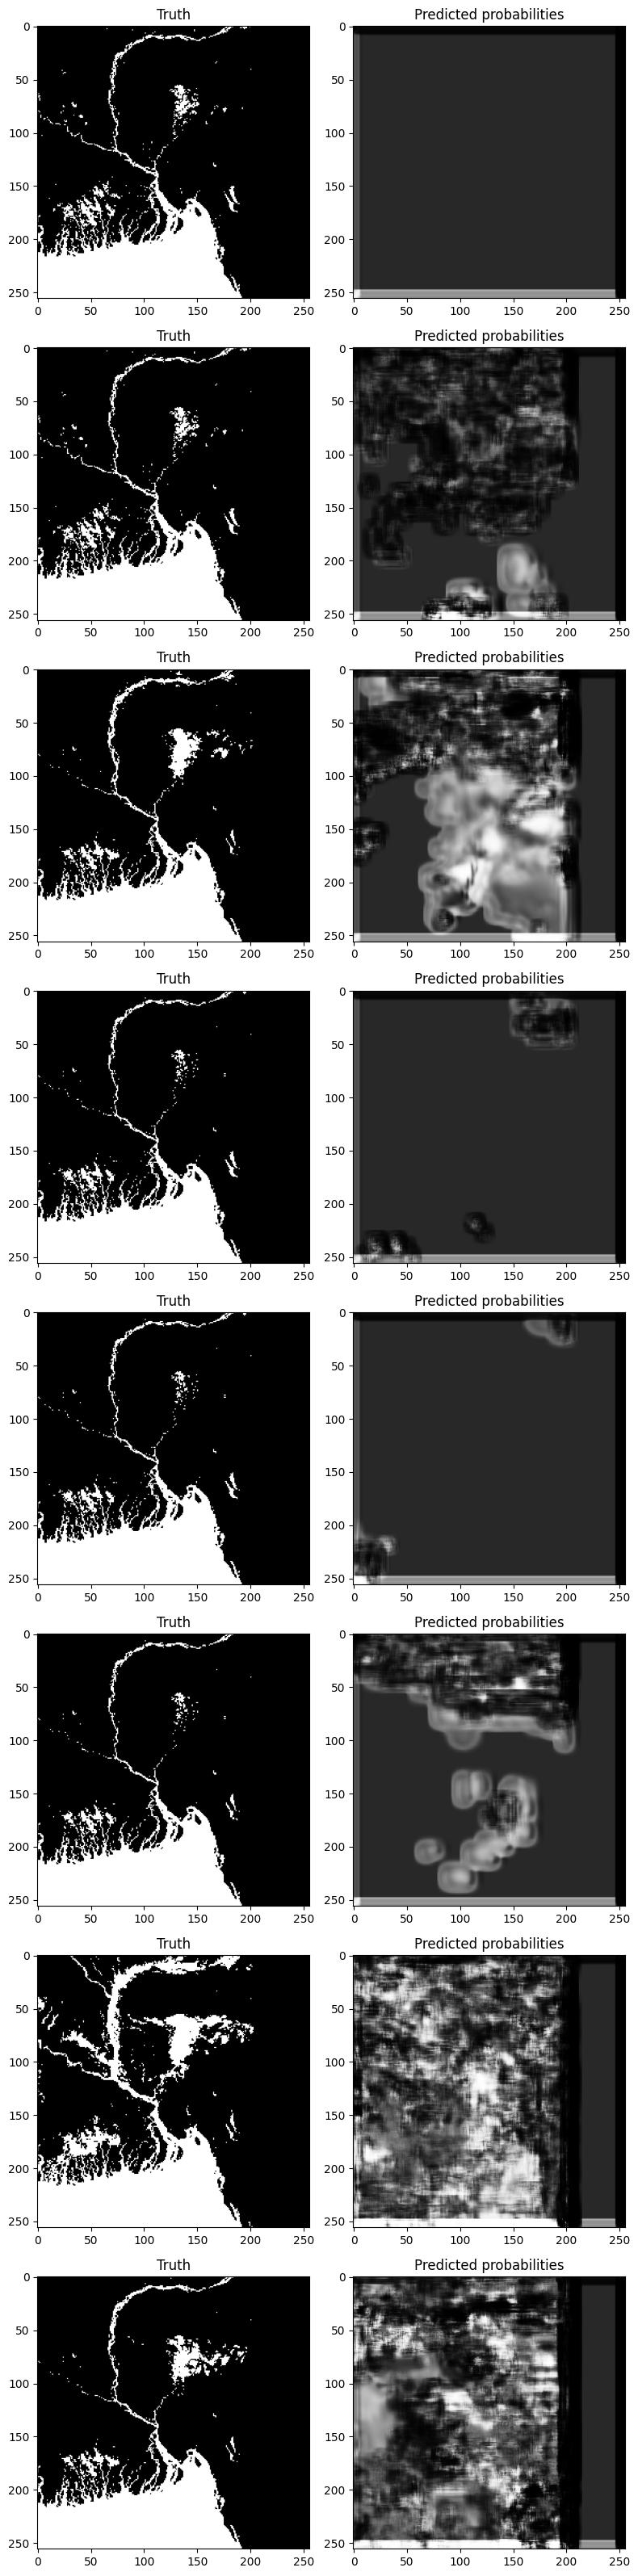

In [4]:
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
cmap = LinearSegmentedColormap.from_list("gray_scale", ["black", "white"])

fig, ax = plt.subplots(8, 2, figsize=(8, 32))
# label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

for i in range(test_batch_size):
    logits_array = outputs[i].squeeze(0).detach().cpu().numpy()
    max_logit = logits_array.max()
    min_logit = logits_array.min()
    mode_logit = stats.mode(logits_array.flatten())

    print(f"Max Logit: {max_logit}, Min Logit: {min_logit}, Mode: {mode_logit}")
    ax[i, 0].imshow(test_labels[i].squeeze(0).cpu(), cmap=cmap, vmin=0, vmax=1)
    ax[i, 0].set_title("Truth")

    ax[i, 1].imshow(logits_array, cmap=cmap, vmin=0, vmax=1)
    ax[i, 1].set_title("Predicted probabilities")

plt.tight_layout()
plt.show()

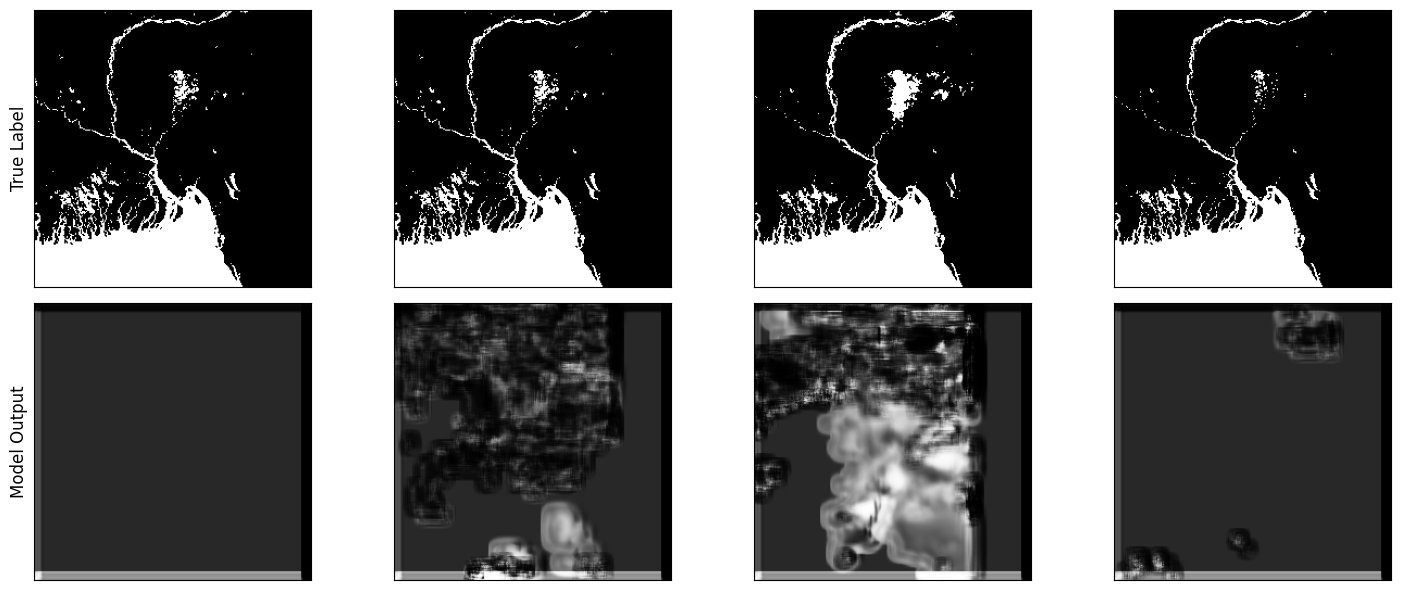

In [14]:
num_images = 4
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))  # Create a grid of subplots

outputs = outputs.cpu().detach()
labels = test_labels.cpu()

# ax.set_ylabel('True Label', rotation=0, size='large')
# ax.set_ylabel('Model Output', rotation=90, size='large')
for i in range(num_images):
    # Display true labels
    ax = axes[0, i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(labels[i], cmap='gray', vmin=0, vmax=1)  # Assuming grayscale images; change cmap if using color images
    # ax.axis('off')  # Hide axes ticks
    if i == 0:
        # ax.set_ylabel('True Label', rotation=0, size='large', labelpad=40)
        ax.set_ylabel('True Label', rotation=90, size='large')
        ax.yaxis.set_label_position("left")

    # Display model outputs
    ax = axes[1, i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(outputs[i], cmap='gray', vmin=0, vmax=1)
    # ax.axis('off')
    if i == 0:
        # ax.set_ylabel('Model Output', rotation=0, size='large', labelpad=40)
        ax.set_ylabel('Model Output', rotation=90, size='large')
        ax.yaxis.set_label_position("left")

fig.tight_layout()
# plt.savefig(filename, bbox_inches='tight')
# plt.close()

In [15]:
epochs = list(range(1, 21))  # 20 epochs

# Example losses for train, validation, and test
train_losses = [0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.42, 
                0.4, 0.38, 0.35, 0.32, 0.3, 0.28, 0.26, 0.25, 0.24, 0.23]
validation_losses = [1.0, 0.95, 0.9, 0.88, 0.85, 0.83, 0.8, 0.78, 0.76, 0.74, 
                     0.73, 0.71, 0.7, 0.68, 0.67, 0.65, 0.64, 0.63, 0.62, 0.61]
test_losses = [1.2, 1.1, 1.05, 1.0, 0.95, 0.92, 0.89, 0.86, 0.84, 0.82, 
               0.8, 0.78, 0.76, 0.74, 0.72, 0.7, 0.68, 0.66, 0.65, 0.63]

# Combine losses in a list as expected by the function
losses = [train_losses, validation_losses, test_losses]

# Example hyperparameters
hyperparams = {
    'Learning Rate': 0.001,
    'Batch Size': 32,
    'Optimizer': 'Adam',
    'Dropout': 0.5,
    'Epochs': 20
}

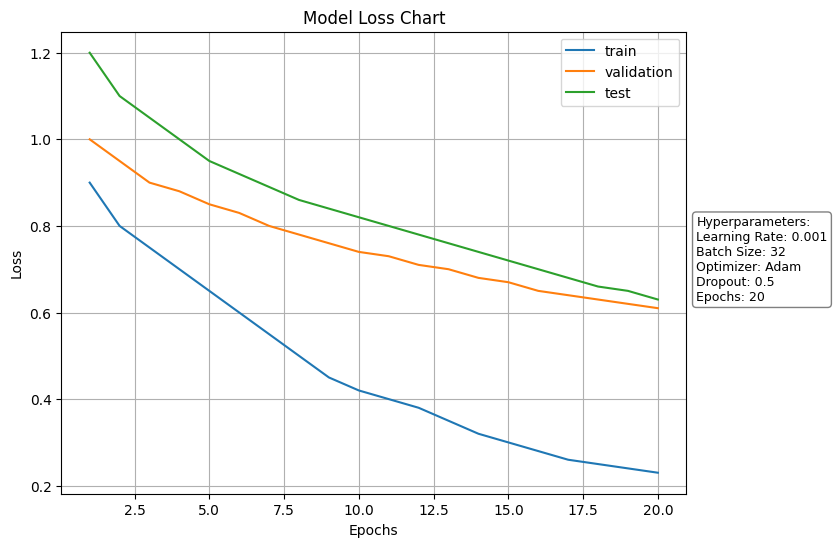

In [19]:
plt.figure(figsize=(10, 6))
labels = ['train', 'validation', 'test']
for i, series in enumerate(losses):
    plt.plot(epochs, series, marker=None, linestyle='-', label=f'{labels[i]}')

# Customize the plot
plt.title("Model Loss Chart")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.subplots_adjust(right=0.75)

hyperparams_text = '\n'.join([f'{key}: {value}' for key, value in hyperparams.items()])
# plt.figtext(0.15, -0.2, "Hyperparameters:\n" + hyperparams_text, fontsize=9, 
#             bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'))
plt.figtext(0.76, 0.5, "Hyperparameters:\n" + hyperparams_text, fontsize=9, 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'), 
            ha='left', va='center')

plt.legend(loc='upper right')
# 